# Evaluate some simple sklearn models and one hard coded base line

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy import interpolate
from random import randint
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline, make_pipeline
import numpy.typing as npt
from tqdm.notebook import tqdm, trange
import pprint
import cv2
import json
import pickle

from utils import get_data, datapath, PadHull, ScaleToImage, FlattenCoordinates, Data, HardCodedEstimator

# reload local imports
%load_ext autoreload
%autoreload 2

In [2]:
n_points_per_hull = 32
image_width, image_height = 640, 480
random_state = 42

pp = pprint.PrettyPrinter()

## 1. Extract data

In [3]:
all_data = [get_data(i, datapath) for i in trange(1, 101)]
X = [vehicle["hull"] for image_pv, image_tv, vehicles_pv,
     vehicles_tv in all_data for vehicle in vehicles_pv]
y = [vehicle["gcp"] for image_pv, image_tv, vehicles_pv,
     vehicles_tv in all_data for vehicle in vehicles_pv]
top_view_gcps = [vehicle["gcp"] for image_pv, image_tv, vehicles_pv,
     vehicles_tv in all_data for vehicle in vehicles_tv]
X = np.array(X, dtype=object)
y = np.array(y)
top_view_gcps = np.array(top_view_gcps)

len(X), len(y)

  0%|          | 0/100 [00:00<?, ?it/s]

(265, 265)

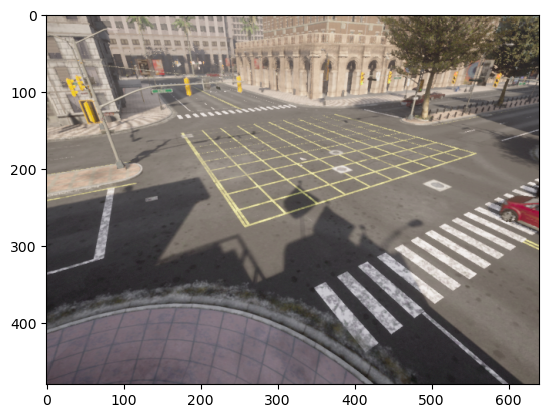

In [4]:
_ = plt.imshow(all_data[0][0])

## 2. Preprocess

1. Pad all hulls to have an equal number of coordinates (32)
2. Scale all hull cordinates to the image size
3. Standard scale them
4. Flatten into shape (64,) (n_coordinates * 2)

In [5]:
image_scaler = ScaleToImage(image_width, image_height)
feature_scaler = StandardScaler()
inverse_pipeline = Pipeline(
    steps=[("Standard scaler", feature_scaler),
           ("Images size scaler", image_scaler)]
)
label_scaler = StandardScaler()
feature_pipeline = Pipeline(
    steps=[("Pad hull", PadHull(False, n_points_per_hull)),
           ("Scale to image", image_scaler),
           ("Flatten coordinates", FlattenCoordinates(n_points_per_hull)),
           #("Standard scaler", feature_scaler)
           ]
)
feature_pipeline

Pipeline(steps=[('Pad hull', PadHull(shuffle=False)),
                ('Scale to image', ScaleToImage(height=480, width=640)),
                ('Flatten coordinates', FlattenCoordinates(n_coordinates=32))])

In [7]:
X_padded = feature_pipeline.fit_transform(X)
#_ = convex_hull_plot_2d(ConvexHull(X_unscaled[0].reshape(32, 2)))
#_ = convex_hull_plot_2d(ConvexHull(X[0]))


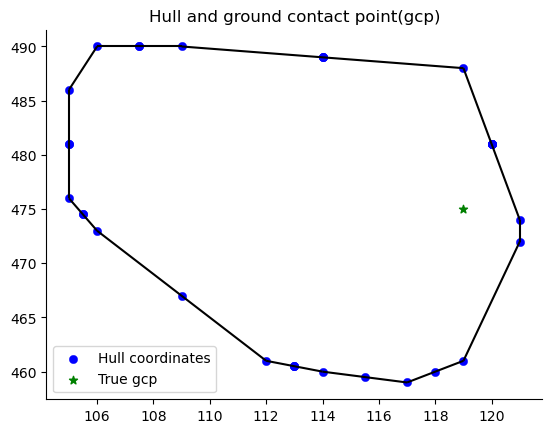

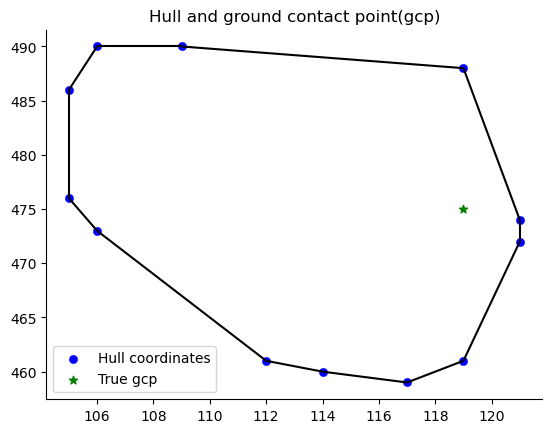

In [8]:
from utils import predict_and_plot

n = 0
_ = predict_and_plot(X_padded[n].reshape(32, 2), y[n], image_size=(image_width, image_height))
_ = predict_and_plot(X[n], y[n], None)


## 3. Evaluation of models

In [9]:
import csv
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
import joblib
from utils import fit_and_score, HardCodedEstimator

scaled_pipeline = make_pipeline(PadHull(False, n_points_per_hull),
                               ScaleToImage(image_width, image_height),
                               FlattenCoordinates(n_points_per_hull),
                               StandardScaler()) # ridge needs standard scaler

non_scaled_pipeline = make_pipeline(PadHull(False, n_points_per_hull),
                            ScaleToImage(image_width, image_height),
                            FlattenCoordinates(n_points_per_hull),
                            StandardScaler())


# commented out models don't work
classifiers = [
    (Ridge(random_state=random_state), scaled_pipeline),
    # RegressorChain(SVR()),
    # MultiOutputRegressor(SVR()),
    (RegressorChain(GradientBoostingRegressor(n_estimators=60, random_state=random_state)), non_scaled_pipeline),
    (MultiOutputRegressor(GradientBoostingRegressor(n_estimators=60, random_state=random_state)), non_scaled_pipeline),
    #RegressorChain(LinearSVR()),
    # MultiOutputRegressor(LinearSVR()),
    (DecisionTreeRegressor(max_depth=18, random_state=random_state), non_scaled_pipeline),
    (HardCodedEstimator("homography_matrix.json", 1), None),
]
evaluation = fit_and_score(classifiers, X, y, random_state=random_state)
with open("./evaluation_baseline.csv", "w") as f:
    w = csv.DictWriter(f, evaluation[0].keys())
    w.writeheader()
    w.writerows(evaluation)
pp.pprint(evaluation)
#_=joblib.dump(evaluation, "classifiers.joblib")

100%|██████████| 5/5 [00:00<00:00,  8.90it/s]

[{'classifier': DecisionTreeRegressor(max_depth=18, random_state=42),
  'pipeline': Pipeline(steps=[('padhull', PadHull(shuffle=False)),
                ('scaletoimage', ScaleToImage(height=480, width=640)),
                ('flattencoordinates', FlattenCoordinates(n_coordinates=32)),
                ('standardscaler', StandardScaler())]),
  'test_mse': 15.273584905660378,
  'train_mse': 0.0},
 {'classifier': RegressorChain(base_estimator=GradientBoostingRegressor(n_estimators=60,
                                                        random_state=42)),
  'pipeline': Pipeline(steps=[('padhull', PadHull(shuffle=False)),
                ('scaletoimage', ScaleToImage(height=480, width=640)),
                ('flattencoordinates', FlattenCoordinates(n_coordinates=32)),
                ('standardscaler', StandardScaler())]),
  'test_mse': 27.99318213719987,
  'train_mse': 0.43873257973168006},
 {'classifier': MultiOutputRegressor(estimator=GradientBoostingRegressor(n_estimators=60,
       

### 3.2 Evaluation of hard coded models

In [10]:
from sklearn.metrics import mean_squared_error
estimator = HardCodedEstimator("./ipm_evaluation/conf/homography_matrix.json", 4)
estimator.fit(X, y)
pred = estimator.predict(X)
error = mean_squared_error(y, pred)
print(error)

212.63967391643243


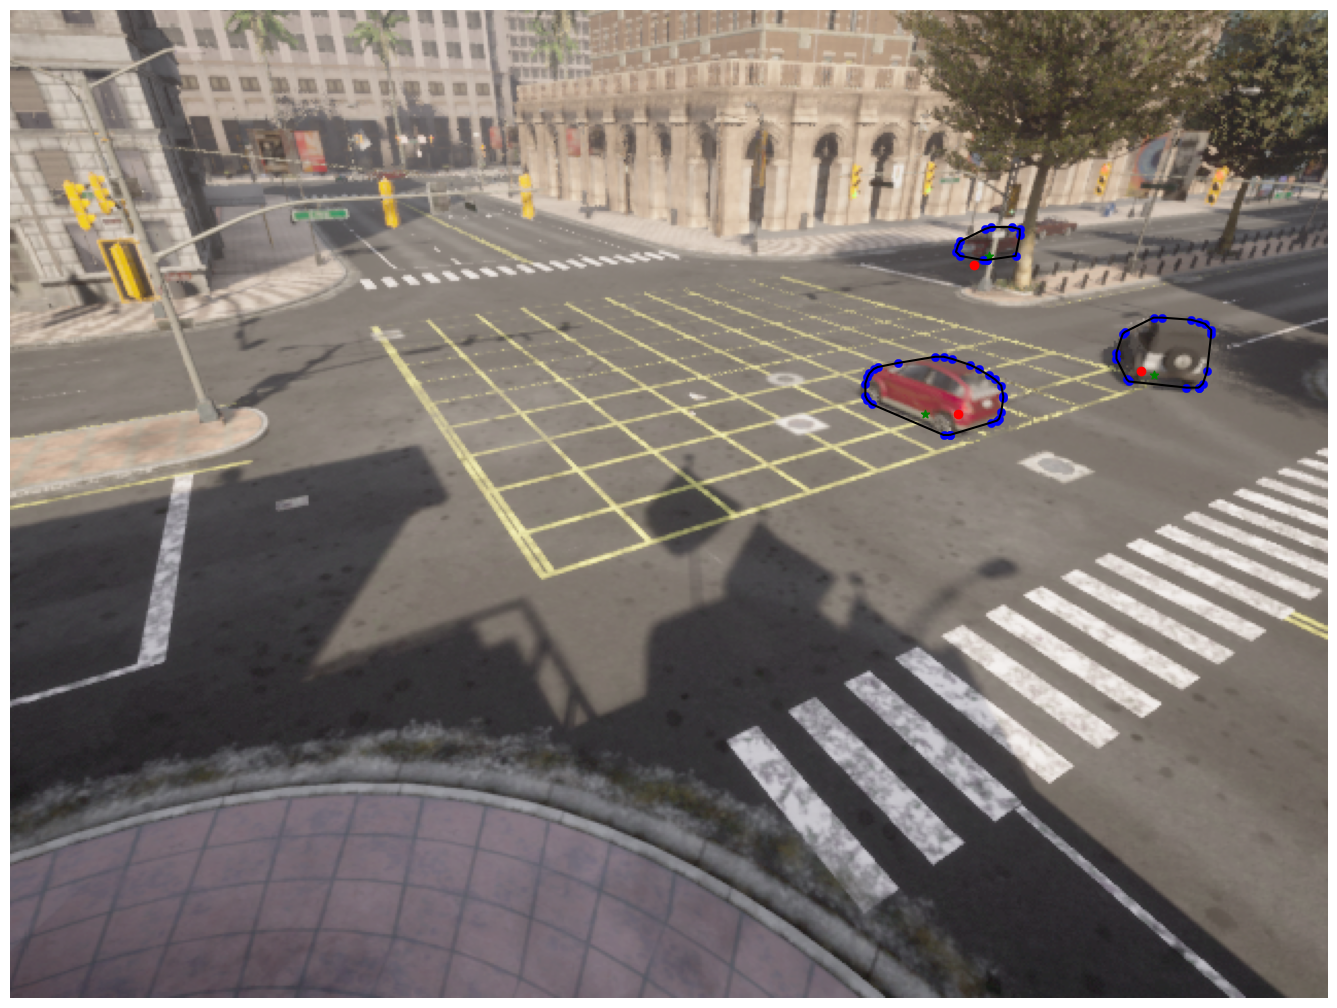

In [11]:
from utils import plot_predictions
n = 24
clf = classifiers[-1]
_=plot_predictions(all_data[n], *clf)

In [11]:
data = all_data[n]
to_pickle = {"homography": homography, "data": data}
with open("bad_sample.pickle", "wb") as f:
    pickle.dump(to_pickle, f)

NameError: name 'homography' is not defined

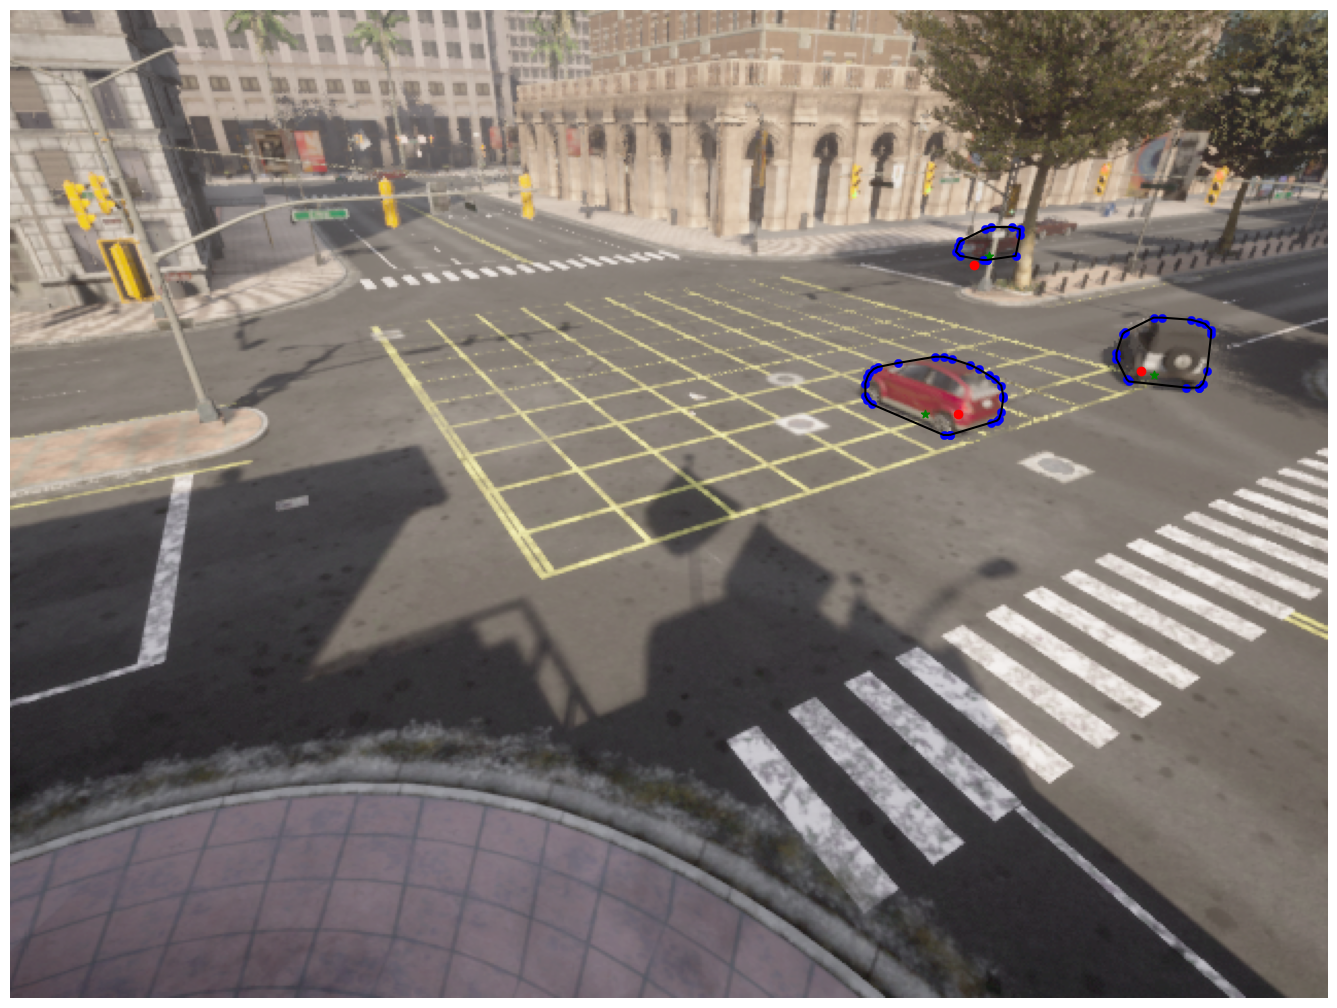

In [12]:
model = HardCodedEstimator("homography_matrix.json", 1)
model.fit(None, None)
_=plot_predictions(all_data[n], model, None)

In [28]:
source = y.astype("float32")
dst = top_view_gcps.astype("float32")
homography, _ = cv2.findHomography(source, dst)
pp.pprint(homography)
with open("homography_matrix.json", "w") as f:
    json.dump(homography.tolist(), f)

array([[-4.07449326e-01, -8.12937538e+00,  8.25162057e+02],
       [ 6.81756015e-01, -6.06104450e+00,  2.59755303e+02],
       [-2.47799764e-05, -1.82750641e-02,  1.00000000e+00]])


In [19]:
gcp_top = top_view_gcps[0]
gcp_bottom = y[0]
temp_point = [gcp_bottom[0], gcp_bottom[1], 1]
warped = np.matmul(homography, temp_point)
scaling = 1 / warped[2]
warped *= scaling
warped, gcp_top

(array([282.99297117, 116.0341541 ,   1.        ]), array([283, 116]))

In [21]:
with open("./ipm_evaluation/conf/homography_matrix.json", "r") as f:
    homography = np.array(json.load(f))

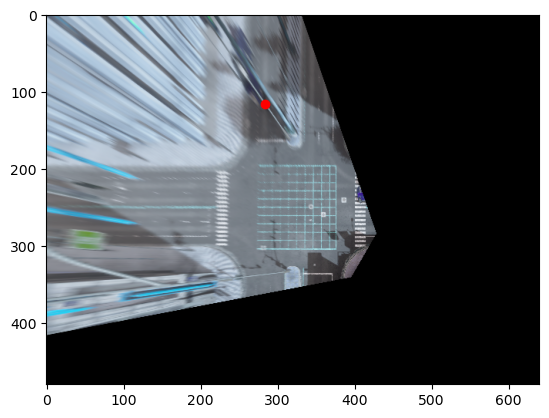

In [24]:
image = cv2.imread("../datasets/carla_dataset/output/pv/255529.png")
image = np.asarray(image)
output = cv2.warpPerspective(image, homography, (image_width, image_height))
plt.scatter(gcp_top[0], gcp_top[1], color="green", marker="*")
plt.scatter(warped[0], warped[1], color="red", marker="o")
plt.imshow(output)

In [ ]:
with open("./bad_sample.pickle", "rb") as f:
    data = pickle.load(f)
data

{'homography': array([[-4.07449326e-01, -8.12937538e+00,  8.25162057e+02],
        [ 6.81756015e-01, -6.06104450e+00,  2.59755303e+02],
        [-2.47799764e-05, -1.82750641e-02,  1.00000000e+00]]),
 'data': Data(image_pv=<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FE3E8B7ACE0>, image_tv=<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480 at 0x7FE3E8C35570>, vehicles_pv=array([{'id': 198, 'gcp': [444, 196], 'psi': [431, 190], 'img': 'output/pv/255553.png', 'bb': [(460, 211), (467, 182), (482, 204), (490, 176), (409, 188), (413, 163), (430, 183), (435, 159)], 'hull': array([[206, 456],
               [200, 476],
               [199, 479],
               [198, 480],
               [195, 481],
               [188, 482],
               [187, 482],
               [182, 481],
               [179, 478],
               [177, 475],
               [174, 470],
               [172, 466],
               [169, 457],
               [168, 453],
               [168, 44

In [ ]:
from bev_new import PositionEstimation
from ipm_evaluation.fivesafe.image_tracking.track import Track

estimator = PositionEstimation("homography_matrix.json", 1)



In [15]:
from utils import plot_hull, plot_gcp

track = Track(None, 1, 1, 1, 1)
image_pv, image_tv, vehicles_pv, vehicles_tv = all_data[10]
_ = plt.imshow(image_pv)
for vehicle in vehicles_pv:
    point, _, ground_contact_points = estimator.map_entity_and_return_relevant_points(track, vehicle["hull"])
    print(ground_contact_points.shape)
    plot_hull(vehicle["hull"])
    plot_gcp(vehicle["gcp"])
    _ = plt.scatter(ground_contact_points[:, 1], ground_contact_points[:, 0], color="blue")

plt.show()

NameError: name 'Track' is not defined